In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.api import ai_client
from src.utils import *
from src.const import *
from src.plots import *
from src.signal_providers.signal_manager import *
from src.news_providers.news_api_provider import *
from src.agents.news_filtering_agent import *
from src.agents.trading_agent import *

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

In [5]:
ai_client.create(
    [
        ai_client.make_msg(
            "You are image descripto. Respond with json of this format: {'description': what you see, 'style': stylistics of the image, 'prompt': short description of charachter, style and cloth}",
            role=ROLE_SYSTEM,
        ),
        ai_client.make_msg(
            text="What's in this image?",
            img="https://cdn.midjourney.com/cef38092-6b61-4ae3-8e78-6d7e71fe14c9/0_2.webp",
        ),
    ],
    format=JSON_MODE,
)

'{\n  "description": "The image depicts a monochrome illustration of a female warrior. She has long flowing hair, striking facial features, and holds a large sword horizontally above her head. She is wearing armor including metallic arm guards and a chest piece that resembles a bikini top, coupled with low-rise trousers. The setting appears to be a simple, lightly shaded background, emphasizing the character in the foreground.",\n  "style": "The image is rendered in a grayscale palette, creating a dramatic and intense atmosphere. The illustration style is detailed, particularly in the rendering of the armor\'s texture and the character\'s hair.",\n  "prompt": "Illustration of a fantasy female warrior wielding a sword, dressed in semi-detailed metallic armor, set against a plain background in grayscale tones."\n}'

In [6]:
plt.plot(np.sin(np.array(range(300)) * 0.1))

ai_client.create(
    [
        ai_client.make_msg(
            "You are image descripto. Respond with json of this format: {'description': what you see, 'style': stylistics of the image}",
            role=ROLE_SYSTEM,
        ),
        ai_client.make_msg(
            text="What's in this image?",
            img=plt,
        ),
    ],
    format=JSON_MODE,
)

'{\n  "description": "The image shows a sinusoidal wave pattern plotted on a grid. The wave oscillates between values of -1.0 and 1.0 across a horizontal axis ranging from 0 to 300. There are multiple complete cycles of the wave visible.",\n  "style": "The image is a simple, clean graphical representation of a sine wave commonly used in mathematics and physics to depict periodic oscillations."\n}'

In [52]:
cutoff = subtract_time(get_current_datetime(), days=0)
day_history = get_day_history("TON", cutoff)
week_history = get_week_history("TON", cutoff)
month_history = get_month_history("TON", cutoff)

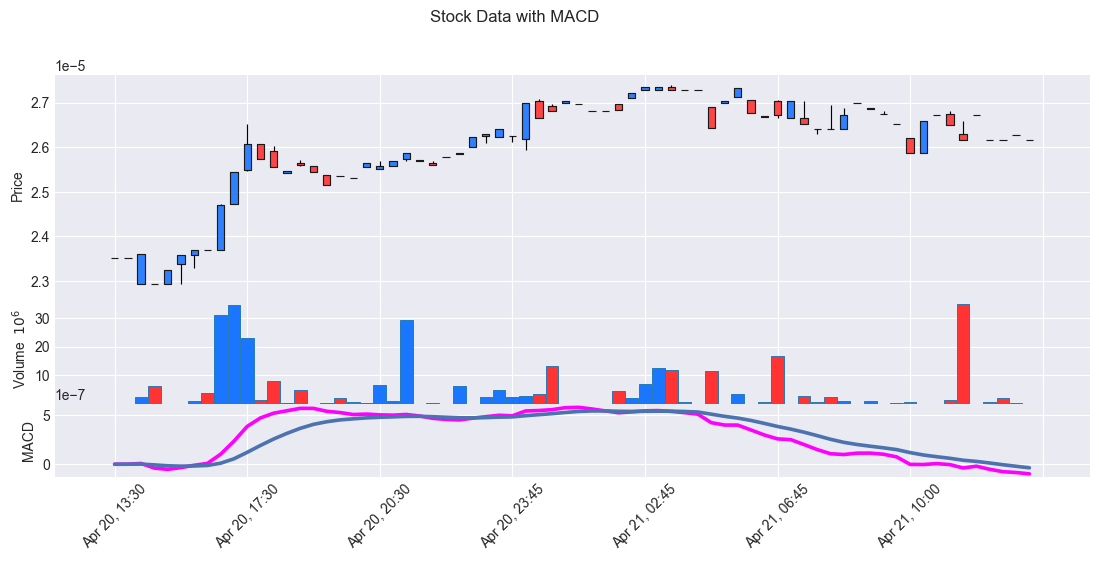

In [53]:
make_candlebars(day_history)

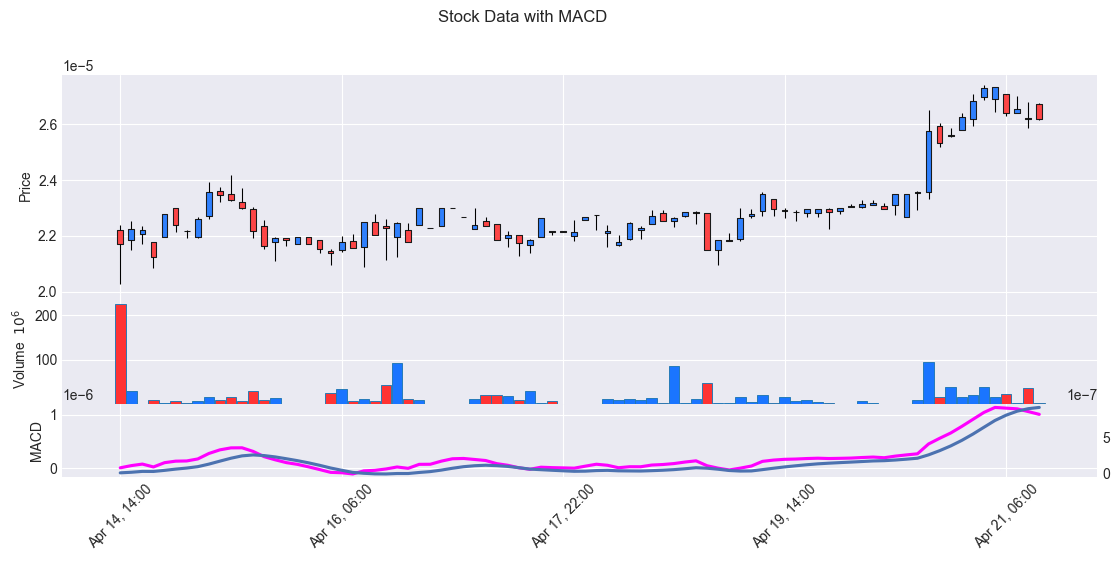

In [54]:
make_candlebars(week_history)

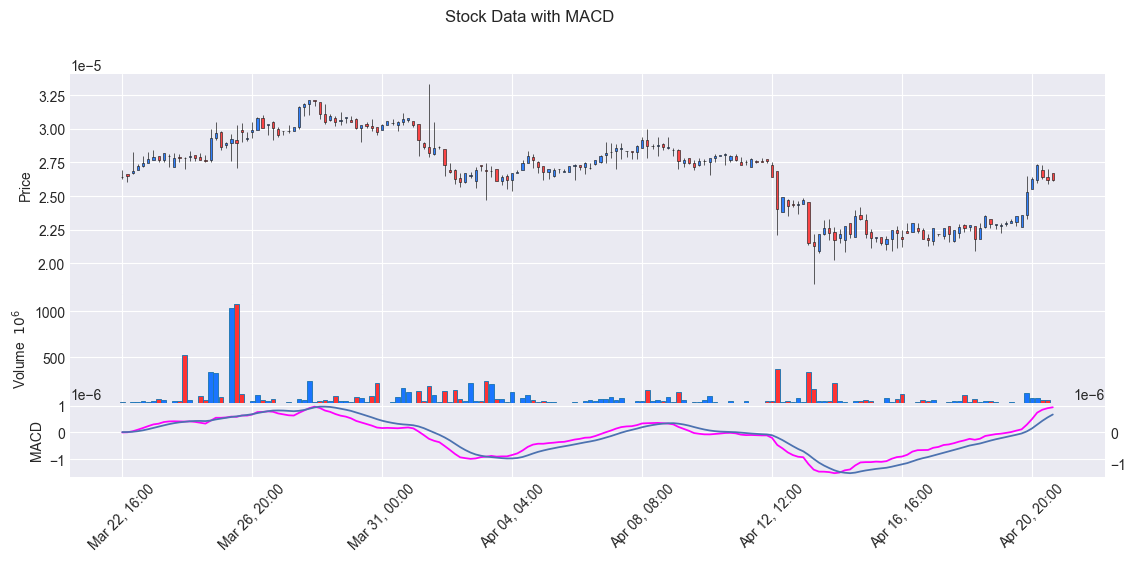

In [55]:
make_candlebars(month_history)

In [56]:
res = ai_client.create(
    [
        ai_client.make_msg(
            "You are professional trader",
            role=ROLE_SYSTEM,
        ),
        ai_client.make_msg(
            text="What is shown on this image, what are the trends and prices? What do you expect prices to be in a week?",
            img=make_candlebars(week_history, useBuf=True),
        ),
    ],
    #format=JSON_MODE,
)

res

'The image you provided displays a financial chart with data points for stock prices (depicted by a candlestick chart), trading volume (shown via bar graph below the price chart), and a MACD (Moving Average Convergence Divergence) indicator (the line graph below the volume chart).\n\n### Analysis of the Components:\n1. **Candlestick Chart**: This is used to detailed price movements within a particular time frame. Each candlestick shows the opening, high, low, and closing prices. The chart indicates some volatility with a generally upward trend reflected in the most recent candles having higher lows.\n\n2. **Volume Bars**: These indicate the volume of shares traded during each time interval. High volume can often relate to significant price movements. Notably, there is a spike in volume around April 14, coinciding with a large price drop, possibly indicating a sell-off.\n\n3. **MACD Lines**: Comprising two lines (usually colored differently) that describe changes in momentum. The pink l

In [50]:
napi = NewsApi()
news = napi.get_news("Toncoin", start_date="2024-04-15")

filtering_agent = NewsFilteringAgent()
filtered_news = filtering_agent.filter_news(news)

json.loads(filtered_news)

{'headlines': ['Telegram to tokenize emojis and stickers as NFTs on TON blockchain',
  'Toncoin Price Jumps 17% As Tether Widens Payment Choices On Telegram’s TON Network',
  'TON-Based Economy Starting to Take Root in Telegram, TON Foundation Says',
  'Toncoin Surges 18% as Market Bounces; Traders Back New Token To Pump Next',
  'Toncoin Defies Market Turmoil, Surges 25% To Tally All-Time High'],
 'sentiment': 'Positive',
 'description': 'Toncoin and the TON blockchain have had significant developments over the past week. For instance, Tether’s announcement that its stablecoin, USDT, and gold-backed XAUT will be accessible on the TON network induced a notable price surge. Telegram has also integrated these stablecoins into their messaging service, making it possible for users to execute transactions directly. Pavel Durov, CEO of Telegram, recently declared the plans to tokenize emojis and stickers as NFTs on the TON Blockchain, further expanding the utility and attractiveness of TON. 

[{'role': 'system', 'content': 'You are professional trader.\n            You have deep knowledge of cryptocurrencies and trading markets, and you can maximize profits the most efficiently.\n            You trade in USDT.\n            \n            You an only buy or sell at the current price, you can not set stop loss.\n            Avoid spending all money in one deal.\n            \n            Respond with json of this format: \n            {\n                \'description\': what you see on charts, general short and long term trends, \n                \'trend_analysys\': rough prediction of near future development of coin,\n                \'techical_analysys\': visual technical analysis of plot and indicators,\n                \'optimal_strategy": optimal trading strategy to maximize profits in this situation,\n                \'final_decision\': what to do, possible variants: \'sell\', \'buy\', \'hold\' (do nothing),\n                \'amount\': amount of coin to buy or sell, 0 i
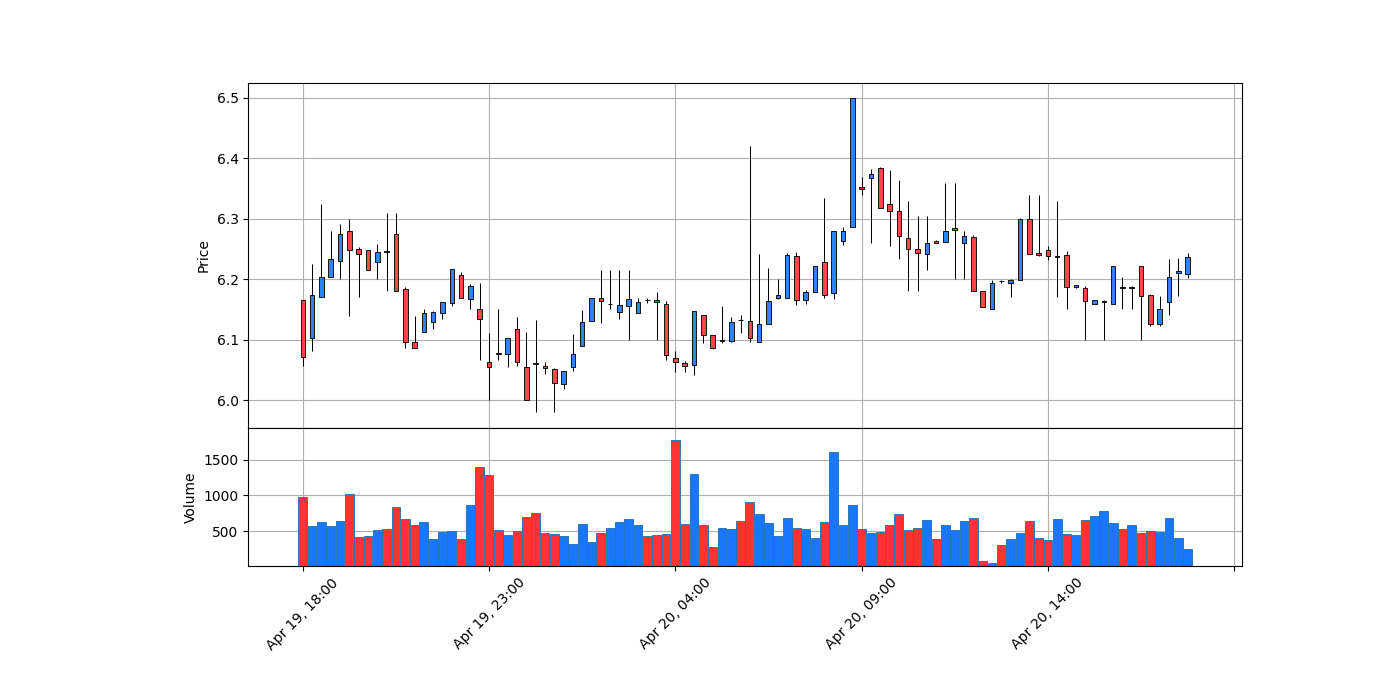
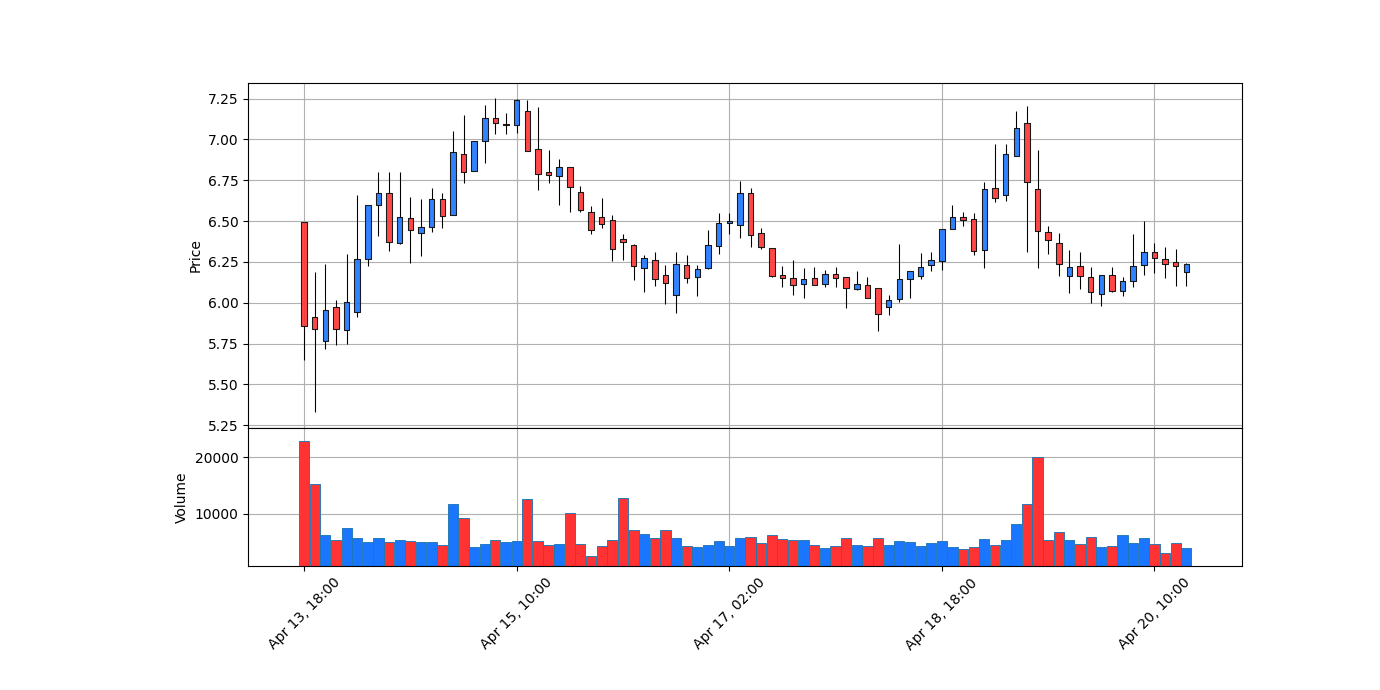
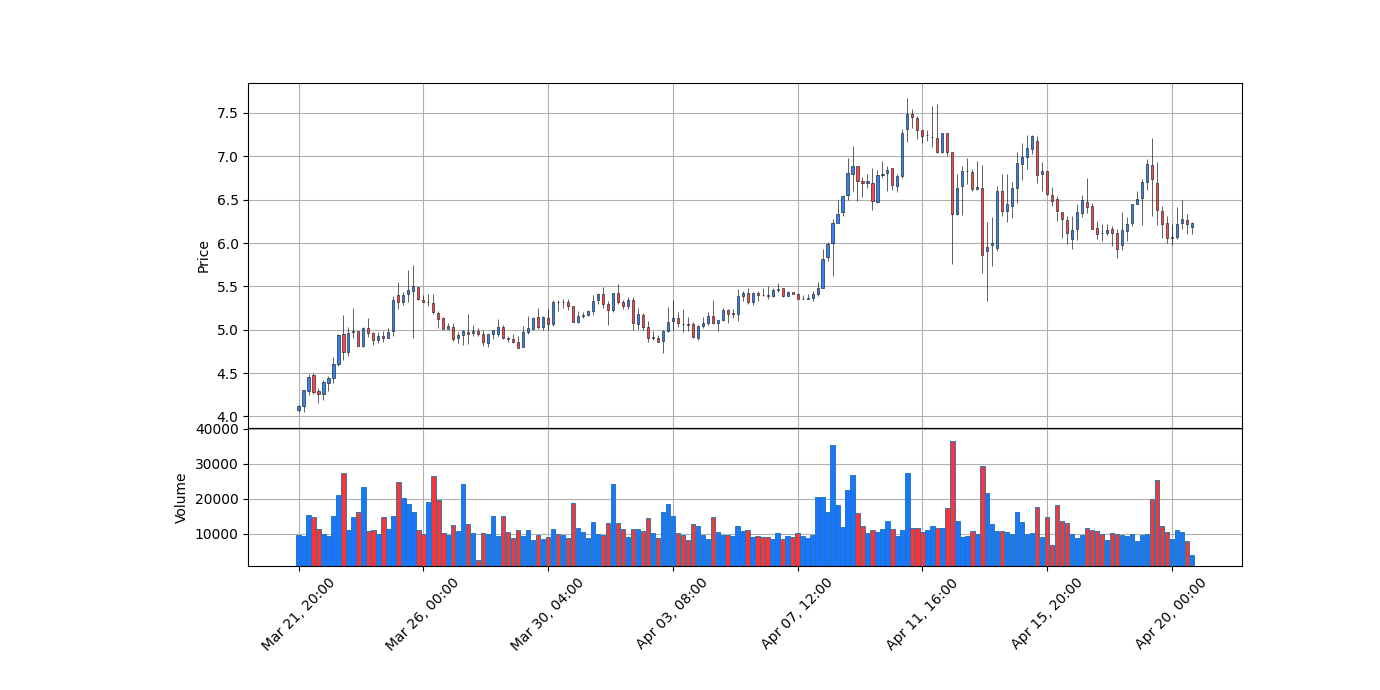

{'description': 'Analyzing the three provided price history charts of TON spanning daily, weekly, and monthly periods, the price action reveals varying dynamics. In the daily chart, the price has fluctuated, showing notable intra-day volatility around the range of $6.0 to $6.5. The weekly chart indicates a decline from a peak of approximately $7.0, stabilizing around $6.25 recently which was also the all-time high reached before declination commenced. The monthly chart shows an overall uptrend, with the price rising from around $4.5 to highs of $7.0 before stabilizing towards the range of $6.0 to $6.5 in recent days. Volume metrics amplify during significant price movements, reflecting heightened trading activity during those periods.',
 'trend_analysis': 'The recent news regarding TON has been overwhelmingly positive, including strategic partnerships and technical advancements like NFT integration and collaborations with Tether. This broadens its ecosystem and market adoption, which c

In [80]:
trading_agent = TradingAgent()
predict = trading_agent.decide(
    coin="TON",
    news=filtered_news,
    day_data=day_history,
    week_data=week_history,
    month_data=month_history,
    operations_history=[
        {"action": "buy", "amount": 1, "price": 6.286, "date": "20.04 08:41"}
    ],
    current_balance={"TON": 1, "USDT": 56.14},
    verbose=True
)

json.loads(predict)